In [1]:
import sys
sys.path.append('../..')
from utils.workflow import WorkflowModel
from utils.data import RK4DataGenerator, stack_real_values, mono_beta
import utils.plotting as plotting
from utils.eval import eval_predictions, format_latex_table
import numpy as np

2026-02-04 13:39:57.248603: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-04 13:39:57.286385: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-04 13:39:58.774010: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float64


E0000 00:00:1770223200.527949  188153 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1770223200.536093  188153 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
t_0, t_f, N = 0, 50, 100
nop_data = 100
S0, I0, R0 = 99, 1, 0
noise_std = N * 0.00
data_t = np.linspace(t_0, t_f, nop_data)
rkdata = RK4DataGenerator(mono_beta, 
    t_0=t_0, 
    t_f=t_f, 
    N=N, 
    S0=S0, I0=I0, R0=R0
)
sir_real = rkdata.generate(data_t)
sir_data = rkdata.generate(data_t, noise_std)

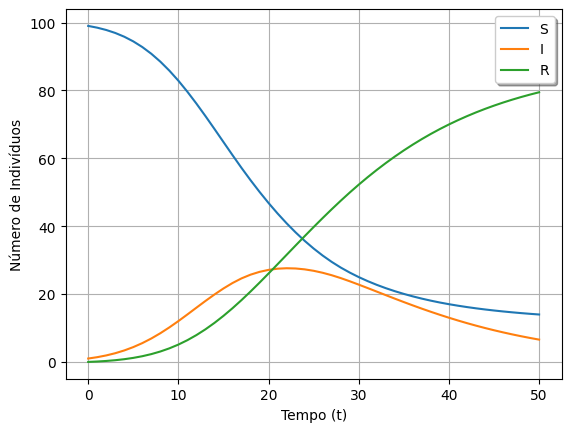

In [3]:
plotting.plot_rk_curves(data_t, sir_real)

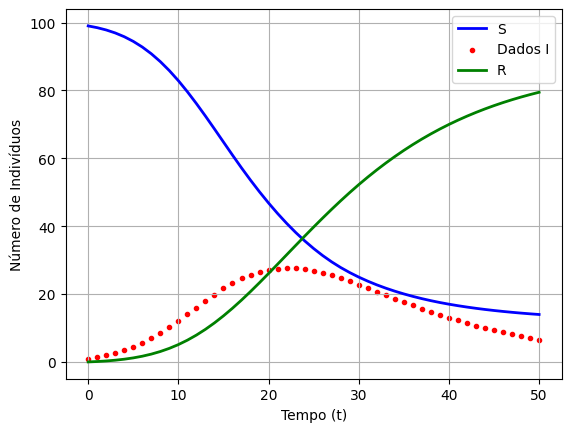

In [4]:
plotting.plot_rk_data(data_t, sir_data, figname="rk-data-mono-beta")

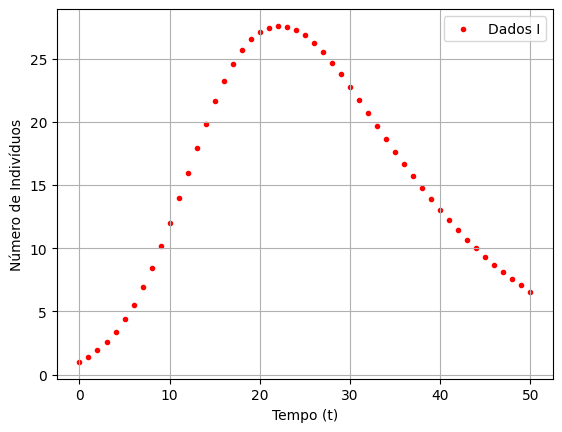

In [5]:
plotting.plot_incidence_data(data_t, sir_data[:,1], "prevalence-example-nonoise")

In [6]:
model = WorkflowModel(t_0, t_f, sir_data[:,1], data_t,
    N=N,
    beta_estimation_window=2,
    hidden_layer_size=50,
    n_hidden_layers=4,
    w_physics=15, 
    scaling="norm",
    activation="tanh",
    adam_iterations=300000,
    parallel_pinns=False, 
    estimate_beta=True,
    early_stopping=True,
    beta_hard_constraints=False,
    adaptative_wdata=False,
    fine_tunning_using_lbfgs=False)
model.S0, model.I0, model.beta0

Compiling model...
'compile' took 0.004735 s



(np.float64(0.99), np.float64(0.01), np.float64(0.4347848116734002))

In [7]:
model.train()

Epoch 101500: early stopping


(<deepxde.model.LossHistory at 0x7f4e2a32e410>,
 <deepxde.model.TrainState at 0x7f4e47a2e3d0>)

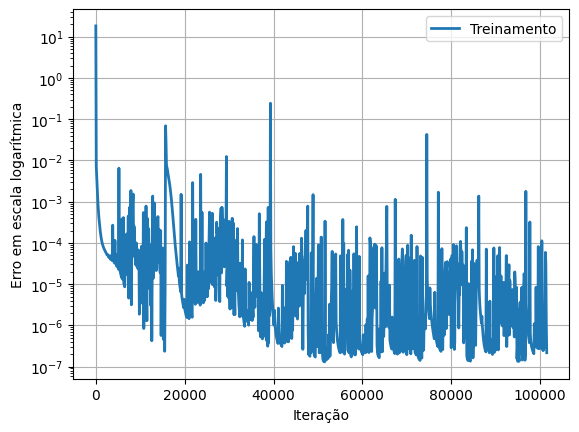

In [8]:
plotting.plot_losshistory(model.losshistory, "loss-mono-beta")

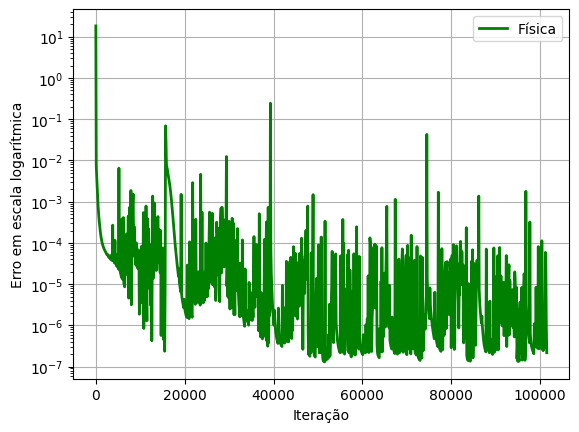

In [9]:
plotting.plot_phys_losshistory(model.losshistory, model.n_physics, "loss-physics-mono-beta")

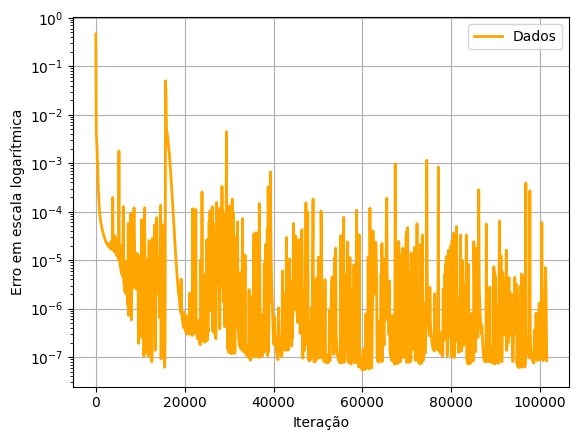

In [10]:
plotting.plot_data_losshistory(model.losshistory, "loss-data-mono-beta")

In [11]:
test_t = np.linspace(t_0, t_f, nop_data)
predictions = model.predict(test_t)

InvalidIndexError: (slice(None, None, None), 0)

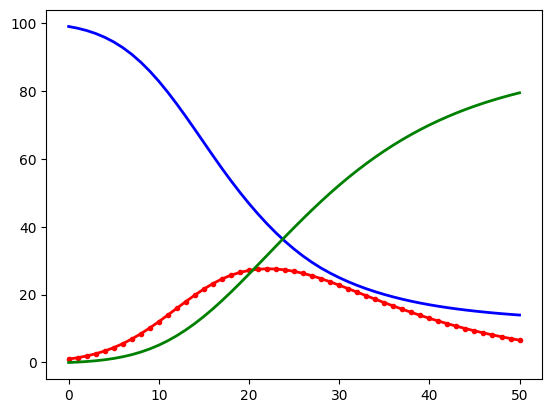

In [19]:
plotting.plot_results(sir_real, sir_data, predictions, test_t, N=N, figname="results-mono-beta")

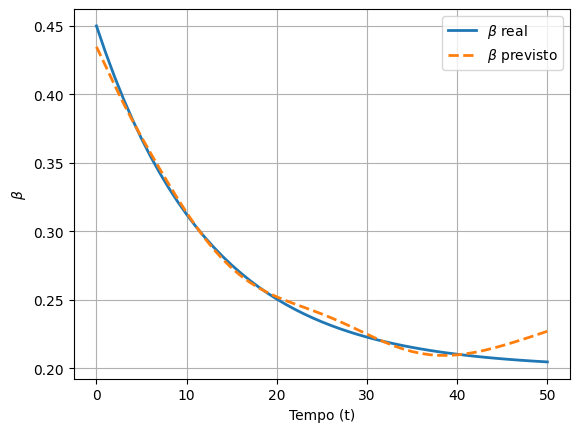

In [13]:
real_beta = mono_beta(test_t)
plotting.plot_beta_comparison(real_beta, predictions[:,2], test_t, figname="predicted-mono-beta")

In [14]:
if model.data_weight_hist:
    plotting.plot_wdata(model.data_weight_hist)

In [15]:
real_values = stack_real_values(sir_real, real_beta)
predictions = eval_predictions(real_values, predictions)

In [16]:
predictions

,compartiment,RMSE,L2,L-infinity
0,S,0.054252,0.000987,0.108293
1,I,0.029043,0.001638,0.056102
2,beta,0.006877,0.025390,0.022394


In [17]:
format_latex_table(predictions)

'\\begin{tabular}{llrrr}\n\\toprule\n & compartiment & RMSE & L2 & L-infinity \\\\\n\\midrule\n0 & S & 0.054252 & 0.000987 & 0.108293 \\\\\n1 & I & 0.029043 & 0.001638 & 0.056102 \\\\\n2 & beta & 0.006877 & 0.025390 & 0.022394 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [18]:
model.formated_total_training_time

'00:02:40'